# Instructions

Work through the assignment 2 notebook, and use this notebook to provide your answers. 

To submit the assignment, you will need to use GitHub and the existing private repository you already created called `adleoxyz` (xyz is your initials)

Once you have completed the assignment:
- Commit your notebook from colab to your private GitHub repo
- The notebook should be named assignment2_xyz.ipynb, with xyz again replaced by your initials.

# Answers to the theoretical questions

Please provide your answers to questions 1-4 here

**Answer to Q1**


An MLP would have a hard time recognizing the test image with a dog on the right as a dog if the train imagaes had all been pictures with dogs on the left. However, a CNN would do a better job, because they are more geared towards identifying local patterns, regardless of where they appear in the image.

**Answer to Q2**

a) 

kernal size = 3x3x3
out channels = 10

The number of trainable parameters is equal to kernel dimensions, times output channels, plus a bias for each kernal::

(3X3X3)x10+10= 280

b) the shape of the bias is a 1x10 vector

c) Computational cost:

Each convolution of a kernal comprises 3x3x3 multiplication operations, plus 26 addition operations (one less than the dimensions of the kernal). This is done 9 times per input channel (output image is 3x3), and this sequence takes place once for each of the 10 kernals (1 kernal per output channel). plus one bias operation for every element of the output tensor.

((kernal size+(kernal size-1))x number of convolutions per kernal x number of kernals (output channels) + output matrix dimensions

((3x3x3)+((3x3x3)-1)x3x3x10+(3x3x10)= 4,770+90=4,860



**Answer to Q3**

**Naive case trainable parameters:**

kernal dimensions x output channels + biases

(5x5x100)x192+192=480,192

**Naive case total cost:**

[kernal dimensions + (kernal dimensions -1)]x output dimensions+ 1 bias for every output dimension

[(5x5x100)+((5x5x100)-1)]x(64x64x192)+(64x64x192)=3,932,160,000


**Inception model trainable parameters:**

(1x1x100)x10+10=1,010


**Inception model total cost**

[kernal dimensions + (kernal dimensions -1)]x output dimensions+ 1 bias for every output dimension

[[(1x1x100)+((1x1x100)-1)]x(64x64)x10+(64x64x10)] + 
[(5x5x10)+((5x5x10)-1]x(5x5x192)+(5x5x192)= 
8,433,230

3,932,160,000:8433230= 462.46:1

**Answer to Q4**

The VGG network introduced the use of 3x3 filters, which allowed more layers to be used in the network, and for the networkd to learn more complex features

GoogLeNet introduced the inception module, which is a combinatoin of 1x1, 3x3, and 5x5 convolutoinal filters. This allows for the filters to learn more complex features. also introduced global average pooling

ResNet introduced a new type of layer called a residual layer, as well as the idea of 'skip connections' which allows the netword to skip over layers in order to better learn features. 

# Coding Assignment 1

Follow the instructions below to complete your coding assignment. 

Run the code below unchanged, unless otherwise indicated. 

## Static code 1

Run unchanged

Mount drive and run imports

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

from IPython.core.debugger import set_trace

## Variables to set

- Model save path: Modify 'save_dir' to the path to your already downloaded MNIST dataset (from assignment 1).

In [ ]:
save_dir = "/content/gdrive/MyDrive/sam_mnist/MNIST/raw"

## Static code 2

### Transforms and loads (Steps 1.1-1.5)

Necessary transforms - run unchanged


In [ ]:
mnist_mean = 0.13066048920154572
mnist_std = 0.30810779333114624

train_transforms = transforms.Compose(
    [transforms.RandomRotation(5, fill=(0,)),
     transforms.RandomCrop(28, padding=2),
     transforms.ToTensor(),
     transforms.Normalize(mean=[mnist_mean], std=[mnist_std])]
     )

test_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[mnist_mean], std=[mnist_std])]
     )

Load and split

In [ ]:
train_data = datasets.MNIST(root=save_dir,
                            train=True,
                            download=False,
                            transform=train_transforms)

test_data = datasets.MNIST(root=save_dir,
                           train=False,
                           download=False,
                           transform=test_transforms)

train_ratio = 0.9

n_train_examples = int(len(train_data) * train_ratio)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,[n_train_examples, 
                                                       n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

Make iterable

In [ ]:
# define batch size first
train_bsize = 54   # training batch size--can change for optional part

In [ ]:
# Don't change this cell
train_loader = data.DataLoader(train_data,
                               shuffle=True,
                               batch_size=train_bsize)

valid_loader = data.DataLoader(valid_data,
                               shuffle=False,
                               batch_size=train_bsize)

test_loader = data.DataLoader(test_data,
                              shuffle=False,
                              batch_size=train_bsize)

### Metrics and some other necessary functions

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = Variable(x).to(device)
        y = Variable(y).to(device)

        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)

        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    # Disable automatic differentiation as we don't do optimization on eval.
    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = Variable(x).to(device)
            y = Variable(y).to(device)

            y_pred = model(x)
            
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


## Task 1: Adjust the model

Modify your MLP as required

In [ ]:
from torch.nn.common_types import T
from pickle import TRUE
class myLeNet(nn.Module):
    def __init__(self, in_dim, num_classes):
        super(myLeNet, self).__init__()
        # feature extraction part
        self.conv1 = nn.Sequential(
              nn.Conv2d(in_channels=in_dim, out_channels=6, kernel_size=5, 
            stride=1, padding=2),
            nn.ReLU(inplace=TRUE)
        )

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, 
            stride=1, padding=0),
            nn.ReLU(inplace=TRUE)
            )

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # classification part
        self.classifier = nn.Sequential(nn.Linear(5*5*16, 120),
                                       nn.LeakyReLU(),
                                       # nn.BatchNorm1d(hidden_dims[0]),
                                       # nn.Dropout(drop_rate),
                                       nn.Linear(120, 84),
                                       nn.LeakyReLU(),
                                       # nn.BatchNorm1d(hidden_dims[1]),
                                       # nn.Dropout(drop_rate),
                                       nn.Linear(84, 10)
        )

    def forward(self, x):  
        # set_trace()                              
        conv1 = self.conv1(x)
        pool1= self.pool1(conv1)
        conv2= self.conv2(pool1)                            
        pool2= self.pool2(conv2)                                                        
        flatten = pool2.view(x.size(0), -1) 
        predict = self.classifier(flatten)                          
        return predict

If you are struggling to get it working, here is a commented out version of the example model that you can run and adapt.  You might want to use some of the other 3 examples that we suggested for structuring the model class

Define the parameters needed to run the model

In [ ]:
in_dim = 1
initial_lr = 0.001    # Hyper-parameter that you can change for optional part
num_epochs = 10    # Hyper-parameter that you can change for optional part

# new variables
num_classes = 10

## Task 2: Show your work

Run and print the model

In [ ]:
# Don't change this cell
model = myLeNet(in_dim, num_classes = num_classes)
print(model)

myLeNet(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


Show the number of parameters in the model

In [ ]:
# Don't change this cell
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 61,706 trainable parameters


Optimizer, loss criterion, and GPU/CPU switch

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=initial_lr)
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

Train the model

In [ ]:
best_val_loss = float('inf')
train_loss_per_epoch = []
val_loss_per_epoch = []
epoch_counter = []

for epoch in trange(num_epochs):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, valid_loader, criterion, device)

    #simple implementation of early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_mlp_tutorial.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')

    epoch_counter.append(epoch)
    train_loss_per_epoch.append(train_loss)
    val_loss_per_epoch.append(val_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 46s
	Train Loss: 0.346 | Train Acc: 89.10%
	 Val. Loss: 0.087 |  Val. Acc: 97.37%


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 45s
	Train Loss: 0.111 | Train Acc: 96.44%
	 Val. Loss: 0.076 |  Val. Acc: 97.42%


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 45s
	Train Loss: 0.082 | Train Acc: 97.39%
	 Val. Loss: 0.052 |  Val. Acc: 98.36%


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 45s
	Train Loss: 0.070 | Train Acc: 97.80%
	 Val. Loss: 0.056 |  Val. Acc: 98.25%


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 46s
	Train Loss: 0.061 | Train Acc: 98.06%
	 Val. Loss: 0.042 |  Val. Acc: 98.76%


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 46s
	Train Loss: 0.056 | Train Acc: 98.20%
	 Val. Loss: 0.047 |  Val. Acc: 98.79%


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 45s
	Train Loss: 0.048 | Train Acc: 98.55%
	 Val. Loss: 0.044 |  Val. Acc: 98.73%


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 46s
	Train Loss: 0.047 | Train Acc: 98.53%
	 Val. Loss: 0.052 |  Val. Acc: 98.33%


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 46s
	Train Loss: 0.045 | Train Acc: 98.58%
	 Val. Loss: 0.033 |  Val. Acc: 99.02%


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 45s
	Train Loss: 0.041 | Train Acc: 98.70%
	 Val. Loss: 0.044 |  Val. Acc: 98.71%


Plot the results

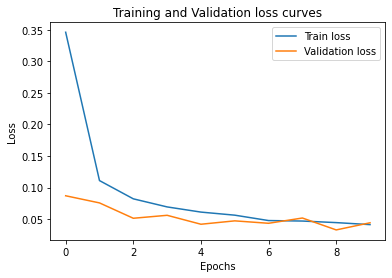

In [ ]:
plt.plot(epoch_counter, train_loss_per_epoch, label="Train loss")
plt.plot(epoch_counter, val_loss_per_epoch, label="Validation loss")
plt.title("Training and Validation loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

Evaluate the performance

In [ ]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/186 [00:00<?, ?it/s]

Test Loss: 0.031 | Test Acc: 99.05%


Show the matrix

## Coding Assignment 2
Download a picture from internet that is among the 1000 classes of the ImageNet dataset labels. Choose five different pre-trained models in torchvision and report the top-1 accuracy related to each model.

Organize your answer like this: Link to the image you have chosen if its available on the web. If the image is in your local machine, you can either upload it in your github repo with the name infer_img_assgn2. Or copy the image to your gdrive and give it permission for everyone with the link (rclick the image --> share with google Drive).

Use the template below to complete this coding assignment.

### Static code 3

This combines the packages and model loads with Step 2, for simplicity

#### Load pre-trained models

Load up models and inspect names. Note that we use here a slightly more compact approach to printing the model names

In [3]:
import requests
import torchvision
import torch.utils.model_zoo as model_zoo
import torchvision.models as models
from PIL import Image

# model names
model_names = sorted(name for name in models.__dict__ \
                     if name.islower() and not name.startswith("__"))
# print(model_names)
mod_index = np.linspace(start=0, stop=len(model_names), num=20) \
              .astype('int').tolist()
for i in range(len(mod_index[:-1])):
    print(model_names[mod_index[i]:mod_index[i+1]])

['_api', '_meta', '_utils', 'alexnet', 'convnext']
['convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet', 'densenet121']
['densenet161', 'densenet169', 'densenet201', 'detection', 'efficientnet', 'efficientnet_b0']
['efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5']
['efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'get_model']
['get_model_builder', 'get_model_weights', 'get_weight', 'googlenet', 'inception', 'inception_v3']
['list_models', 'maxvit', 'maxvit_t', 'mnasnet', 'mnasnet0_5', 'mnasnet0_75']
['mnasnet1_0', 'mnasnet1_3', 'mobilenet', 'mobilenet_v2', 'mobilenet_v3_large']
['mobilenet_v3_small', 'mobilenetv2', 'mobilenetv3', 'optical_flow', 'quantization', 'regnet']
['regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf']
['regnet_x_8gf', 'regnet_y_128gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf', 

#### Step 2: transform function 

Needed to make your selected image fit with the model


In [4]:
transform = transforms.Compose([            
  transforms.Resize(256),                    
  transforms.CenterCrop(224),                
  transforms.ToTensor(),                     
  transforms.Normalize(                      
    mean=[0.485, 0.456, 0.406],                
    std=[0.229, 0.224, 0.225]                  
  )])


### Dynamic code - change once

#### Step 3: Load up your image

Remember to replace either the URL with one points to the image you want to classify, if it is different (and different is more interesting!), or if you are downloading your image, comment out the load from url `Image.open` line and uncomment the load from file version, with your correct file path in it.

In [5]:
# url = ("My Drive/Deep_Learnin_Colab_Notebooks/Jackfruit.jpg")
# img = Image.open(requests.get(url, stream=True).raw)
# uncomment this one to load in downloaded image, adjust path as needed
img = Image.open("/content/gdrive/My Drive/Deep_Learnin_Colab_Notebooks/Jackfruit.jpg") 

img = img.convert("RGB")
img_trans = transform(img)
batch_t = torch.unsqueeze(img_trans, 0)
img  ## this lets us see your image

Output hidden; open in https://colab.research.google.com to view.

#### Step 4: Load up class definitions
Use either the downloaded version, or, for the extra 1 point, show the method you used to pull it directly from its url. 

Downloaded version

In [6]:
# Change the path accordingly
imagenet_class_path = "/content/gdrive/My Drive/Deep_Learnin_Colab_Notebooks/imagenet_classes.txt"
with open(imagenet_class_path) as f:
    labels = [line.strip() for line in f.readlines()]

### Assignment code (5X)

Run each of your 5 model versions here. You will repeat the parts of Step 4 needed to run the models, as demonstrated in the next cells

#### Demo

In [7]:
# create model objects and look at its internals
alexnet = models.alexnet(pretrained=True)  # model
print(alexnet)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Check out the pooling layer and classifier. Note the name of the pooling layers will be different in different models. Please change accordingly. 

In [8]:
print(alexnet.avgpool)
print("%" * 20)
print(alexnet.classifier)

AdaptiveAvgPool2d(output_size=(6, 6))
%%%%%%%%%%%%%%%%%%%%
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


Report the accuracy metrics

In [9]:
alexnet.eval()
out_vec = alexnet(batch_t)
print(out_vec.shape)

print("%" * 20)
percentage = torch.nn.functional.softmax(out_vec, dim=1)[0] * 100
_, indices = torch.sort(out_vec, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

torch.Size([1, 1000])
%%%%%%%%%%%%%%%%%%%%


[('951, lemon', 99.99949645996094),
 ('984, rapeseed', 8.817662455840036e-05),
 ('27, eft', 7.456525054294616e-05),
 ('947, mushroom', 5.7103705330519006e-05),
 ('993, gyromitra', 5.283561040414497e-05)]

#### Model 1

In [10]:
# create model objects and look at its internals
resnet18 = models.resnet18(pretrained=True)
print(resnet18)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
print(resnet18.layer1)
print("%" * 20)
print(resnet18.layer2)
print("%" * 20)
print(resnet18.layer3)
print("%" * 20)
print(resnet18.layer4)
print("%" * 20)
print(resnet18.avgpool)

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
%%%%%%%%%%%%%%%%%%%%
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (b

In [12]:
resnet18.eval()
out_vec = resnet18(batch_t)
print(out_vec.shape)

print("%" * 20)
percentage = torch.nn.functional.softmax(out_vec, dim=1)[0] * 100
_, indices = torch.sort(out_vec, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

torch.Size([1, 1000])
%%%%%%%%%%%%%%%%%%%%


[('951, lemon', 99.99160766601562),
 ('595, harvester', 0.005995643325150013),
 ('947, mushroom', 0.0006700271624140441),
 ('105, koala', 0.0003698516229633242),
 ('824, stole', 0.00017075812502298504)]

#### Model 2

In [ ]:
import torchvision.models as models

In [13]:
squeezenet = models.squeezenet1_0(pretrained=True)
print(squeezenet)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [15]:
print(squeezenet.features)
print("%" * 20)
print(squeezenet.classifier)

Sequential(
  (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (3): Fire(
    (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (4): Fire(
    (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (5): Fire(
    (squeeze): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
   

In [18]:
squeezenet.eval()
out_vec = squeezenet(batch_t)
print(out_vec.shape)

print("%" * 20)
percentage = torch.nn.functional.softmax(out_vec, dim=1)[0] * 100
_, indices = torch.sort(out_vec, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

torch.Size([1, 1000])
%%%%%%%%%%%%%%%%%%%%


[('951, lemon', 99.9667739868164),
 ('36, terrapin', 0.006569148041307926),
 ('947, mushroom', 0.005679217632859945),
 ('984, rapeseed', 0.003450616728514433),
 ('42, agama', 0.003422915004193783)]

#### Model 3

In [19]:
shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
print(shufflenet)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth


  0%|          | 0.00/8.79M [00:00<?, ?B/s]

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [20]:
print(shufflenet.conv1)
print("%" * 20)
print(shufflenet.maxpool)
print("%" * 20)
print(shufflenet.stage3)

Sequential(
  (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)
%%%%%%%%%%%%%%%%%%%%
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
%%%%%%%%%%%%%%%%%%%%
Sequential(
  (0): InvertedResidual(
    (branch1): Sequential(
      (0): Conv2d(116, 116, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=116, bias=False)
      (1): BatchNorm2d(116, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv2d(116, 116, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): BatchNorm2d(116, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
    )
    (branch2): Sequential(
      (0): Conv2d(116, 116, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(116, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(

In [21]:
shufflenet.eval()
out_vec =shufflenet(batch_t)
print(out_vec.shape)

print("%" * 20)
percentage = torch.nn.functional.softmax(out_vec, dim=1)[0] * 100
_, indices = torch.sort(out_vec, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

torch.Size([1, 1000])
%%%%%%%%%%%%%%%%%%%%


[('951, lemon', 99.99671936035156),
 ('948, Granny_Smith', 0.0005552388029173017),
 ('406, altar', 0.00020325553487055004),
 ('993, gyromitra', 0.0001546804269310087),
 ('147, grey_whale', 9.624460653867573e-05)]

#### Model 4

In [22]:
mnasnet = models.mnasnet1_0(pretrained=True)
print(mnasnet)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MNASNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=MNASNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mnasnet1.0_top1_73.512-f206786ef8.pth" to /root/.cache/torch/hub/checkpoints/mnasnet1.0_top1_73.512-f206786ef8.pth


  0%|          | 0.00/16.9M [00:00<?, ?B/s]

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

In [24]:
print(mnasnet.layers)
print("%" * 20)
print(mnasnet.classifier)
print("%" * 20)
# print(shufflenet.stage3)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
  (8): Sequential(
    (0): _InvertedResidual(
      (layers): Sequential(
        (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 

In [25]:
mnasnet.eval()
out_vec = mnasnet(batch_t)
print(out_vec.shape)

print("%" * 20)
percentage = torch.nn.functional.softmax(out_vec, dim=1)[0] * 100
_, indices = torch.sort(out_vec, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

torch.Size([1, 1000])
%%%%%%%%%%%%%%%%%%%%


[('951, lemon', 99.99972534179688),
 ('947, mushroom', 0.00014762995124328882),
 ('51, triceratops', 5.364464595913887e-05),
 ('105, koala', 2.4474706151522696e-05),
 ('944, artichoke', 1.9207031073165126e-05)]

#### Model 5

In [17]:
googlenet = models.googlenet(pretrained=True)
print(googlenet)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [26]:
print(googlenet.maxpool1)
print("%" * 20)
print(googlenet.inception4b)
print("%" * 20)
print(googlenet.dropout)

MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
%%%%%%%%%%%%%%%%%%%%
Inception(
  (branch1): BasicConv2d(
    (conv): Conv2d(512, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (branch2): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(512, 112, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(112, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(112, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(224, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (branch3): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(512, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (con

In [28]:
googlenet.eval()
out_vec = googlenet(batch_t)
print(out_vec.shape)

print("%" * 20)
percentage = torch.nn.functional.softmax(out_vec, dim=1)[0] * 100
_, indices = torch.sort(out_vec, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

torch.Size([1, 1000])
%%%%%%%%%%%%%%%%%%%%


[('951, lemon', 99.03059387207031),
 ('948, Granny_Smith', 0.047687236219644547),
 ('993, gyromitra', 0.03801070153713226),
 ('984, rapeseed', 0.03262330964207649),
 ('105, koala', 0.028633294627070427)]